# Forward Modelling of a Many Lines Spectrum using DIT

Here, we try to compute a emission spectrum using DIT.

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit
from exojax.spec import lpf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

We set a wavenumber grid using nugrid. Specify xsmode="dit" though it is not mandatory.
DIT uses FFT, so the (internal) wavenumber grid should be linear. 
But, you can also use a nonlinear grid. In this case, the interpolation (jnp.interp) is used.   

In [3]:
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(22900,23000,10000,unit="AA",xsmode="dit")

nugrid is linear: mode= dit


Loading a molecular database of CO and CIA (H2-H2)... 

In [4]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
H2-H2


In [5]:
from exojax.spec import molinfo
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [6]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [7]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [8]:
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)

And line strength

In [9]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

DIT requires the grids of sigmaD, gammaL, and wavenumber. For the emission spectrum, this grids should be prepared for each layer. 
dit.dgmatrix can compute these grids.   

In [10]:
dgm_sigmaD=dit.dgmatrix(sigmaDM)
dgm_gammaL=dit.dgmatrix(gammaLM)

#you can change the resolution 
#dgm_sigmaD=dit.dgmatrix(sigmaDM,res=0.1)
#dgm_gammaL=dit.dgmatrix(gammaLM,res=0.1)

We can check how the grids are set for each layers using plot.ditplot.plot_dgm 

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


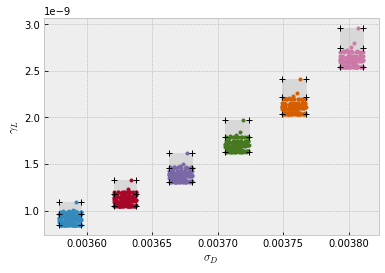

In [11]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgm
plot_dgm(dgm_sigmaD,dgm_gammaL,sigmaDM,gammaLM,0,6)

We need to specify Nfold. But, I do not want to check Nfold for each layer. 
For convinience, dit.sigma_voigt can be used to estimate the minimum line width and dit.autoNfold can be used to determine the adequate Nfold.

In [12]:
#check adequate Nfold
sigma=dit.sigma_voigt(dgm_sigmaD,dgm_gammaL)
dnu=nus[1]-nus[0]
relres,Nfold=dit.autoNfold(sigma,dnu,1.5)
print("Nfold=",Nfold)

Nfold= 1


For DIT in exojax, we also need to precompute "dLarray". 
The aliasing effect may results in some negative values in the computed cross section, in particular, when the grid resolution is comparable or smaller than to the line width. We can avoid this effect by including the aliased part of the distribution. Nfold is the number of aliasing to be included. dLarray is just a list (1,2,3,...,Nfold)/dnu, where dnu is the wavenumber interval. We can use dit.make_dLarray to compute dLarray.  

In [13]:
dLarray=dit.make_dLarray(Nfold,dnu)

For the wavenumber grid, we need to be careful for the truncation error. 
One of the conservative ways is to use numpy.float64 for the computation
For this case, npnc1D (=numpy neibouring contribution 1D) is used to prepare a precomputed grid using numpy.float64.
Then, dit.xsmatrix can use to compute the cross section matrix. But, this is a bit time-consuming.  xsmatrix has the shape of (# of layers, # of nu grid)

In [14]:
#here we use the precomputed NCF for wavenumber
nu_ncf=dit.npnc1D(mdbCO.nu_lines,nus)
xsmdit=dit.xsmatrix(nu_ncf,sigmaDM,gammaLM,SijM,nus,dgm_sigmaD,dgm_gammaL,dLarray)

100%|██████████| 10000/10000 [00:00<00:00, 119587.83it/s]


Instead, we can compute a 3D grid for  sigmaD,gammaL, wavenumber, simultaneously, using dit.xsvector3D. In this case, we should be careful. Here, we subtract large number from both wavenumber grids and line centers to avoid the truncatino error. This is faster than precomputed NCF.

In [15]:
# or 3D version
xsmdit3D=dit.xsmatrix3D(mdbCO.nu_lines-np.median(nus),sigmaDM,gammaLM,\
SijM,nus-np.median(nus),dgm_sigmaD,dgm_gammaL,dLarray)

We also compute the cross section using the direct computation (LPF) for the comparison purpose.

In [16]:
#direct LPF for comparison
from exojax.spec import make_numatrix0
from exojax.spec.lpf import xsmatrix
numatrix=make_numatrix0(nus,mdbCO.nu_lines)
xsmdirect=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

Let's see the cross section matrix!

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


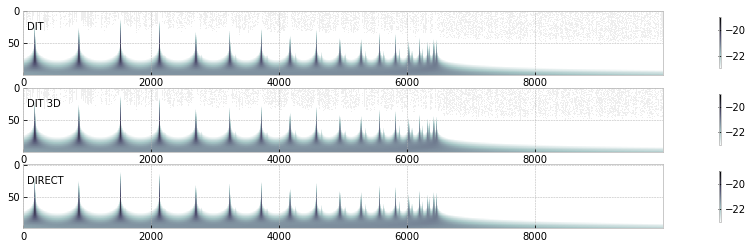

In [17]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(311)
c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT")
ax.set_aspect(0.1/ax.get_data_ratio())
ax=fig.add_subplot(312)
c=plt.imshow(np.log10(xsmdit3D),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT 3D")
ax.set_aspect(0.1/ax.get_data_ratio())
ax=fig.add_subplot(313)
c=plt.imshow(np.log10(xsmdirect),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIRECT")
ax.set_aspect(0.1/ax.get_data_ratio())
plt.show()

computing delta tau for CO

In [18]:
from exojax.spec.rtransfer import dtauM
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsmdit,MMR*np.ones_like(Tarr),molmassCO,g)
dtaum3D=dtauM(dParr,xsmdit3D,MMR*np.ones_like(Tarr),molmassCO,g)

In [19]:
dtaumdirect=dtauM(dParr,xsmdirect,MMR*np.ones_like(Tarr),molmassCO,g)

computing delta tau for CIA

In [20]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [21]:
dtau=dtaum+dtaucH2H2
dtau3D=dtaum3D+dtaucH2H2
dtaudirect=dtaumdirect+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

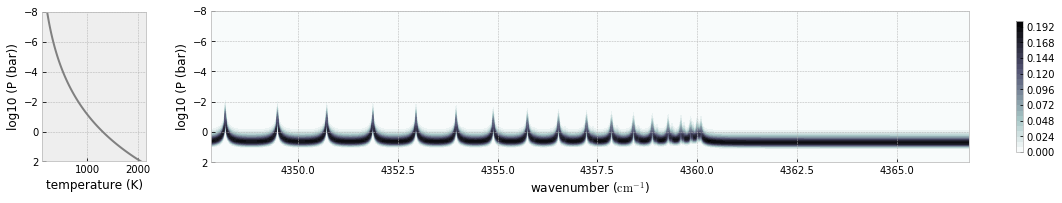

In [22]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [23]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)
F03D=rtrun(dtau3D,sourcef)
F0direct=rtrun(dtaudirect,sourcef)

The difference is very small except around the edge (even for this it's only 1%).

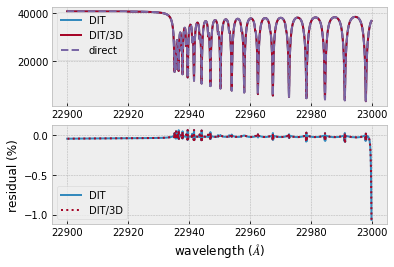

In [26]:
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,label="DIT")
plt.plot(wav[::-1],F03D,label="DIT/3D")
plt.plot(wav[::-1],F0direct,ls="dashed",label="direct")
plt.legend()
ax=fig.add_subplot(212)
plt.plot(wav[::-1],(F0-F0direct)/np.median(F0direct)*100,label="DIT")
plt.plot(wav[::-1],(F03D-F0direct)/np.median(F0direct)*100,label="DIT/3D",ls="dotted")
plt.legend()
plt.ylabel("residual (%)")
plt.xlabel("wavelength ($\AA$)")
plt.show()

To apply response, we need to convert the wavenumber grid from ESLIN to ESLOG. 

In [27]:
import jax.numpy as jnp
nuslog=np.logspace(np.log10(nus[0]),np.log10(nus[-1]),len(nus))
F0log=jnp.interp(nuslog,nus,F0)

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [28]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nuslog,F0log,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nuslog,Frot,beta,RV)

(22920, 23000)

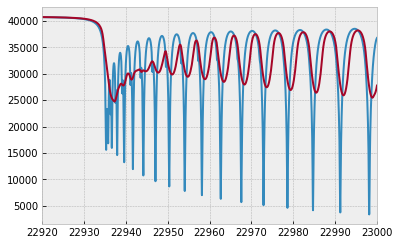

In [29]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)
plt.xlim(22920,23000)